In [1]:
# Install required packages
!pip install -U transformers torch torchvision pillow matplotlib opencv-python

In [2]:
!pip install -U git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-qzxg0ilp
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-qzxg0ilp
  Resolved https://github.com/huggingface/transformers.git to commit 40dc11cd3eb4126652aa41ef8272525affd4a636
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
# 1) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from huggingface_hub import login
login()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from transformers import Sam3Processor, Sam3Model

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

model.eval()

Using device: cuda


config.json:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

processor_config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

Sam3Model(
  (vision_encoder): Sam3VisionModel(
    (backbone): Sam3ViTModel(
      (embeddings): Sam3ViTEmbeddings(
        (patch_embeddings): Sam3ViTPatchEmbeddings(
          (projection): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (layer_norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (layers): ModuleList(
        (0-31): 32 x Sam3ViTLayer(
          (layer_norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (rotary_emb): Sam3ViTRotaryEmbedding()
          (attention): Sam3ViTRoPEAttention(
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (o_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm2): LayerNorm((1024,

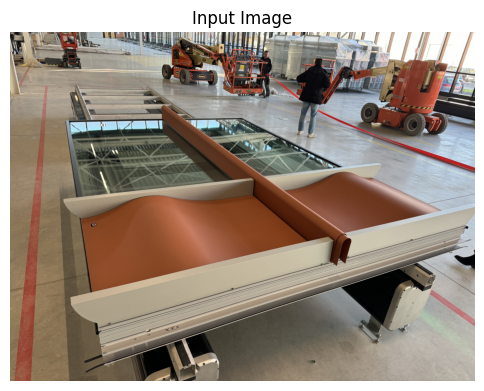

In [13]:
from PIL import Image
import matplotlib.pyplot as plt

IMAGE_PATH = "/content/drive/MyDrive/Neodata Hackathon 2025/sample_images/9_1.jpg"
image = Image.open(IMAGE_PATH).convert("RGB")

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title("Input Image")
plt.show()

In [14]:
import torch
import numpy as np
import matplotlib
from PIL import Image as PILImage

# Sentence prompt (change freely)
prompt = "orange area"
# try: "hole", "glass", "rubber gasket", "metal sheet", "aluminum profile"

inputs = processor(
    images=image,
    text=prompt,
    return_tensors="pt"
).to(device)

with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.6,          # confidence threshold
    mask_threshold=0.5,     # binarization threshold
    target_sizes=inputs["original_sizes"].tolist()
)[0]

print(f"Prompt: '{prompt}' | Found {len(results['masks'])} instances")

Prompt: 'orange area' | Found 2 instances


In [15]:
def overlay_masks(image, masks):
    image = image.convert("RGBA")
    masks = (255 * masks.cpu().numpy()).astype(np.uint8)

    n_masks = masks.shape[0]
    if n_masks == 0:
        return image

    cmap = matplotlib.colormaps.get_cmap("rainbow").resampled(n_masks)
    colors = [tuple(int(c * 255) for c in cmap(i)[:3]) for i in range(n_masks)]

    for mask, color in zip(masks, colors):
        mask_img = PILImage.fromarray(mask)
        overlay = PILImage.new("RGBA", image.size, color + (0,))
        alpha = mask_img.point(lambda v: int(v * 0.5))
        overlay.putalpha(alpha)
        image = PILImage.alpha_composite(image, overlay)

    return image

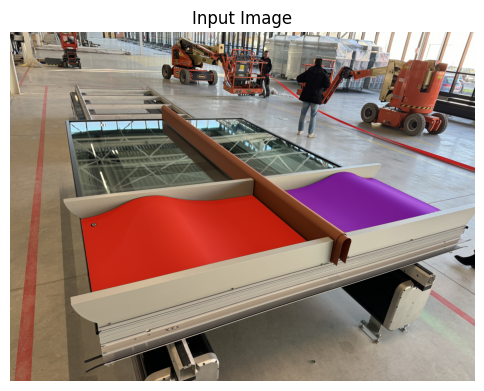

In [16]:
viz = overlay_masks(image, results["masks"])
plt.figure(figsize=(6, 6))
plt.imshow(viz)
plt.axis("off")
plt.title("Input Image")
plt.show()